In [1]:
import fasttext
import fasttext.util
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

ROOT = os.path.dirname(os.path.abspath(""))
ROOT

# cosine similarity
def cos_sim(a, b):
	return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load document 0 **images, ocr, questions & answers**

In [2]:
import json
from PIL import Image

name_d0 = os.listdir("ocr")[0][:8]
filenames_d0 = [file[:-5] for file in os.listdir("ocr") if name_d0 in file]
filenames_d0 = sorted(filenames_d0, key=lambda x: int(x[10:]))

# OCR
ocr_d0 = [json.load(open(f"ocr/{file}.json")) for file in filenames_d0]

# Images
img_d0 = [Image.open(f"images/{file}.jpg") for file in filenames_d0]

# Questions and Answers
dataset = json.load(open("qas/train.json"))
qas_d0 = [qa for qa in dataset["data"] if qa["doc_id"] == name_d0]

# Fasttext
Load Fasttext

In [2]:
print("Loading fasttext model...")
if not os.path.exists(os.path.join(ROOT, "cc.en.300.bin")):
	fasttext.util.download_model('en', if_exists='ignore')
model = fasttext.load_model(os.path.join(ROOT, "cc.en.300.bin"))

Loading fasttext model...


In [3]:
dim_fasttext = model.get_dimension()
dim_fasttext

300

In [4]:
model.get_sentence_vector("Hello World").shape,\
model.get_word_vector("Hello").shape

((300,), (300,))

Extract embeddings from first question and possible answers

In [6]:
qas_d0[0].keys()

dict_keys(['questionId', 'question', 'doc_id', 'page_ids', 'answers', 'answer_page_idx', 'data_split'])

In [96]:
quest0_d0 = qas_d0[0]["question"]
ansrs0_d0 = qas_d0[0]["answers"]
quest0_d0, ansrs0_d0

('What is the name of the person to whom this resume belongs to?',
 ['Ei Soon Cho'])

In [19]:
embs_quest0_d0 = model.get_sentence_vector(quest0_d0)
embs_ansrs0_d0 = [model.get_sentence_vector(ansr) for ansr in ansrs0_d0]
embs_ansrs0_d0 = np.array(embs_ansrs0_d0)
embs_quest0_d0.shape, embs_ansrs0_d0.shape

((300,), (1, 300))

Extract embeddings from first page OCR

In [9]:
ocr_d0[0].keys(), ocr_d0[0]["LINE"][0].keys()

(dict_keys(['PAGE', 'LINE', 'WORD']),
 dict_keys(['BlockType', 'Confidence', 'Text', 'Geometry', 'Id', 'Relationships']))

In [10]:
lines_ocr0_d0 = [line["Text"] for line in ocr_d0[0]["LINE"]]
lines_ocr0_d0[:15]

['CHO, Ei SOON',
 'Page 1',
 'F.L.',
 'NF',
 'THE NUTRITION FOUNOATION,',
 '489 FIFTH AVENUE NEW YORK, . NEW YORK 10017',
 '(212)',
 '68',
 'JUL 5',
 '1978',
 'Application for Grant-in-Aid',
 'Date: June 21, 1978',
 'Ei Soon Cho',
 '1. Applicant:',
 'Assistant Professor, Department of Home Economics']

In [18]:
embs_ocr0_d0 = [model.get_sentence_vector(line) for line in lines_ocr0_d0]
embs_ocr0_d0 = np.array(embs_ocr0_d0)
embs_ocr0_d0.shape

(59, 300)

Compare question embeddings with OCR embeddigs

In [20]:
embs_quest0_d0 = torch.tensor(embs_quest0_d0, device=device)
embs_ansrs0_d0 = torch.tensor(embs_ansrs0_d0, device=device)
embs_ocr0_d0 = torch.tensor(embs_ocr0_d0, device=device)

device(type='cuda')

In [21]:
sim_quest0_ocr0_d0 = [cos_sim(embs_quest0_d0, emb) for emb in embs_ocr0_d0]
sim_quest0_ocr0_d0 = torch.tensor(sim_quest0_ocr0_d0, device=device)
sim_quest0_ocr0_d0.shape

torch.Size([59])

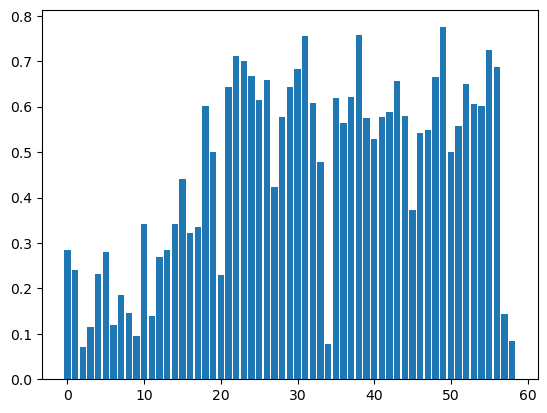

In [22]:
plt.bar(range(len(sim_quest0_ocr0_d0)), sim_quest0_ocr0_d0.cpu().numpy())
plt.show()

In [24]:
# sort by similarity
sorted_indices = torch.argsort(sim_quest0_ocr0_d0, descending=True)
most_similar_chunks = [lines_ocr0_d0[i] for i in sorted_indices[:5]]
most_similar_chunks

['upon each other, and upon the ability of the organism to convert',
 'for the very young or premature infant; and b) the increasing use of',
 'lead/cysteine depletion. It is hoped that this information will help to',
 'cystine or cysteine. They interpreted the data to indicate that 80%',
 'Present data indicate that cystine is an essential for some premature']

# BERT

In [4]:
import random
from transformers import BertTokenizer, BertModel

# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

Load BERT

In [5]:
# Load BERT tokenizer and model
tokenizer: BertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model: BertModel = BertModel.from_pretrained('bert-base-uncased')

Extract embeddings from first question and possible answers

In [6]:
quest0_d0 = qas_d0[0]["question"]
ansrs0_d0 = qas_d0[0]["answers"]
quest0_d0, ansrs0_d0

('What is the name of the person to whom this resume belongs to?',
 ['Ei Soon Cho'])

In [7]:
enc_quest0_d0 = tokenizer.batch_encode_plus( [quest0_d0],# List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',      # Return PyTorch tensors
    add_special_tokens=True    # Add special tokens CLS and SEP,
)
enc_ansrs0_d0 = tokenizer.batch_encode_plus( ansrs0_d0,
	padding=True,
	truncation=True,
	return_tensors='pt',
	add_special_tokens=True
)
enc_quest0_d0.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
tokenizer.decode(enc_quest0_d0["input_ids"][0]),\
tokenizer.decode(enc_ansrs0_d0["input_ids"][0])

('[CLS] what is the name of the person to whom this resume belongs to? [SEP]',
 '[CLS] ei soon cho [SEP]')

In [9]:
with torch.no_grad():
    outputs = model(enc_quest0_d0["input_ids"], attention_mask=enc_quest0_d0["attention_mask"])
    embs_quest0_d0 = outputs.last_hidden_state
    outputs = model(enc_ansrs0_d0["input_ids"], attention_mask=enc_ansrs0_d0["attention_mask"])
    embs_ansrs0_d0 = outputs.last_hidden_state
len(quest0_d0.split()), len(ansrs0_d0[0].split()),\
enc_quest0_d0["input_ids"].shape, enc_ansrs0_d0["input_ids"].shape,\
embs_quest0_d0.shape, embs_ansrs0_d0.shape

(13,
 3,
 torch.Size([1, 16]),
 torch.Size([1, 6]),
 torch.Size([1, 16, 768]),
 torch.Size([1, 6, 768]))

In [10]:
# Take the CLS token embedding as the sentence embedding
embs_quest0_d0 = embs_quest0_d0[:, 0, :]
embs_ansrs0_d0 = embs_ansrs0_d0[:, 0, :]
embs_quest0_d0.shape, embs_ansrs0_d0.shape

(torch.Size([1, 768]), torch.Size([1, 768]))

Extract embeddings from first page OCR

In [11]:
lines_ocr0_d0 = [line["Text"] for line in ocr_d0[0]["LINE"]]
lines_ocr0_d0[:5]

['CHO, Ei SOON', 'Page 1', 'F.L.', 'NF', 'THE NUTRITION FOUNOATION,']

In [12]:
enc_ocr0_d0 = tokenizer.batch_encode_plus(lines_ocr0_d0,
	padding=True,
	truncation=True,
	return_tensors='pt',
	add_special_tokens=True
)
enc_ocr0_d0["input_ids"].shape

torch.Size([59, 30])

In [13]:
with torch.no_grad():
    outputs = model(enc_ocr0_d0["input_ids"], attention_mask=enc_ocr0_d0["attention_mask"])
    embs_ocr0_d0 = outputs.last_hidden_state
embs_ocr0_d0 = embs_ocr0_d0[:, 0, :]
embs_ocr0_d0.shape

torch.Size([59, 768])

Compare question embeddings with OCR embeddigs

In [14]:
embs_quest0_d0 = embs_quest0_d0.to(device).squeeze(0)
embs_ansrs0_d0 = embs_ansrs0_d0.to(device)
embs_ocr0_d0 = embs_ocr0_d0.to(device)

In [15]:
sim_quest0_ocr0_d0 = [cos_sim(embs_quest0_d0, emb) for emb in embs_ocr0_d0]
sim_quest0_ocr0_d0 = torch.tensor(sim_quest0_ocr0_d0, device=device)
sim_quest0_ocr0_d0.shape

torch.Size([59])

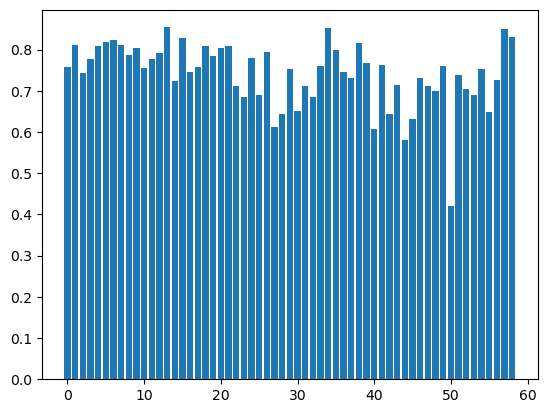

In [16]:
plt.bar(range(len(sim_quest0_ocr0_d0)), sim_quest0_ocr0_d0.cpu().numpy())
plt.show()

In [17]:
# sort by similarity
sorted_indices = torch.argsort(sim_quest0_ocr0_d0, descending=True)
most_similar_chunks = [lines_ocr0_d0[i] for i in sorted_indices[:5]]
most_similar_chunks

['1. Applicant:',
 'Introduction:',
 '(continued)',
 'Source:',
 '2. Position and institution:']

# Let's automate this

In [18]:
from typing import Tuple, Literal, List, Union
from tqdm import tqdm

class RAG:
	def __init__(
		self,
		device: torch.device,
		model_type: Literal["fasttext", "bert"]="bert",
	):
		self.device = device
		self.model_type = model_type
		if model_type == "fasttext":
			print("Loading fasttext model...")
			if not os.path.exists(os.path.join(ROOT, "cc.en.300.bin")):
				fasttext.util.download_model('en', if_exists='ignore')
			self.fasttext_model = fasttext.load_model(os.path.join(ROOT, "cc.en.300.bin"))
			self.dim = self.fasttext_model.get_dimension()
		elif model_type == "bert":
			self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
			self.model = BertModel.from_pretrained('bert-base-uncased')
			self.dim = 768
		else:
			raise ValueError("model should be either 'fasttext' or 'bert'.")
		
	def encode(self, text: str) -> torch.Tensor:
		if self.model_type == "fasttext":
			return torch.tensor(self.fasttext_model.get_sentence_vector(text), device=self.device)
		elif self.model_type == "bert":
			enc = self.tokenizer.batch_encode_plus([text], padding=True, truncation=True, return_tensors='pt', add_special_tokens=True)
			with torch.no_grad():
				outputs = self.model(enc["input_ids"], attention_mask=enc["attention_mask"])
				return outputs.last_hidden_state[:, 0, :]
	
	def precompute_encodings(self, doc_idx: int):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		lines_ocrX_dX = [[line["Text"] for line in ocr_dX[page]["LINE"]] for page in range(len(ocr_dX))]

		print("Encoding lines...")
		embs_lines = [[self.encode(line) for line in page_lines] for page_lines in tqdm(lines_ocrX_dX)]
		embs_lines = [torch.stack(page_lines) for page_lines in embs_lines]

		print("Saving encodings...")
		torch.save(embs_lines, f"encodings_{name_dX}.pt")

	def most_similar(
			self,
			quest: str,
			lines: List[List[str]],
			embs_lines: List[torch.Tensor],
			topk: int = 5,
			similarity_type: Literal["cosine", "dot"]="cosine"
	) -> List[Tuple[int, str]]:
		print("Encoding")
		embs_quest = self.encode(quest)

		# Compute similarity in a vectorized manner
		print("Computing similarity")
		sims_list = []
		for page_embs in embs_lines:
			page_embs = page_embs.squeeze(1) # [num_lines, dim]
			if similarity_type == "cosine":
				norms_quest = torch.norm(embs_quest) # scalar
				norms_lines = torch.norm(page_embs, dim=1) # [num_lines]
				sims = torch.matmul(page_embs, embs_quest.T).squeeze(1) / (norms_quest * norms_lines) # [num_lines, num_lines]
			elif similarity_type == "dot":
				sims = torch.matmul(embs_quest, page_embs.T)
			else:
				raise ValueError("type should be either 'cosine' or 'dot'.")
			sims_list.append(sims)

		# Flatten the similarities and get the top-k indices
		print("Sorting")
		print(sims_list[0].shape, sims_list[1].shape)
		sims_flat = torch.cat(sims_list)
		sorted_indices = torch.argsort(sims_flat, descending=True)[:topk]

		# Retrieve the most similar lines
		print("Retrieving")
		most_similar_lines = []
		for idx in sorted_indices:
			page_idx = 0
			while idx >= len(sims_list[page_idx]):
				idx -= len(sims_list[page_idx])
				page_idx += 1
			most_similar_lines.append((page_idx, lines[page_idx][idx.item()]))

		return most_similar_lines  # [(page_idx, line), ...]

	def foo(
			self,
			doc_idx: int,
			quest_idx: int,
			topk: int=5,
			use_precomputed: bool = True
	):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		lines_ocrX_dX = [[line["Text"] for line in ocr_dX[page]["LINE"]] for page in range(len(ocr_dX))]
		trainset = json.load(open("qas/train.json"))
		qas_dX = [qa for qa in trainset["data"] if qa["doc_id"] == name_dX]
		questX_dX = qas_dX[quest_idx]["question"]
		ansrsX_dX = qas_dX[quest_idx]

		if use_precomputed and os.path.exists(f"encodings_{name_dX}.pt"):
			print("Loading precomputed encodings...")
			embs_lines = torch.load(f"encodings_{name_dX}.pt")
		else:
			print("Encoding lines...")
			embs_lines = [[self.encode(line) for line in page_lines] for page_lines in tqdm(lines_ocrX_dX)]
			embs_lines = [torch.stack(page_lines) for page_lines in embs_lines]

		print("Computing most similar lines...")
		most_similar_lines = self.most_similar(questX_dX, lines_ocrX_dX, embs_lines, topk)
		print("-" * 20)

		print(f"Question:\n- {questX_dX}")
		print("Most similar OCR lines:")
		for i, (page_idx, line) in enumerate(most_similar_lines):
			print(f"Page {page_idx} - {line}")
		print(f"Actual answers in page: {ansrsX_dX['answer_page_idx']}")
		for ansr in ansrsX_dX["answers"]:
			print(f"- {ansr}")
		print("page_ids:", ansrsX_dX["page_ids"])
		

rag = RAG(device, model_type="bert")
rag.foo(
	doc_idx=0,
	quest_idx=2
)

Loading data...
Loading precomputed encodings...
Computing most similar lines...
Encoding
Computing similarity
Sorting
torch.Size([59]) torch.Size([56])
Retrieving
--------------------
Question:
- What is the date of birth given this resume
Most similar OCR lines:
Page 10 - (Detail below)
Page 7 - with the needed time on the analytical instruments (see attached letter
Page 10 - (Specify Below)
Page 15 - telephone number)
Page 7 - Reference cited: Attached
Actual answers in page: 3
- August 6, 1942
page_ids: ['txcx0227_p15', 'txcx0227_p16', 'txcx0227_p17', 'txcx0227_p18', 'txcx0227_p19']


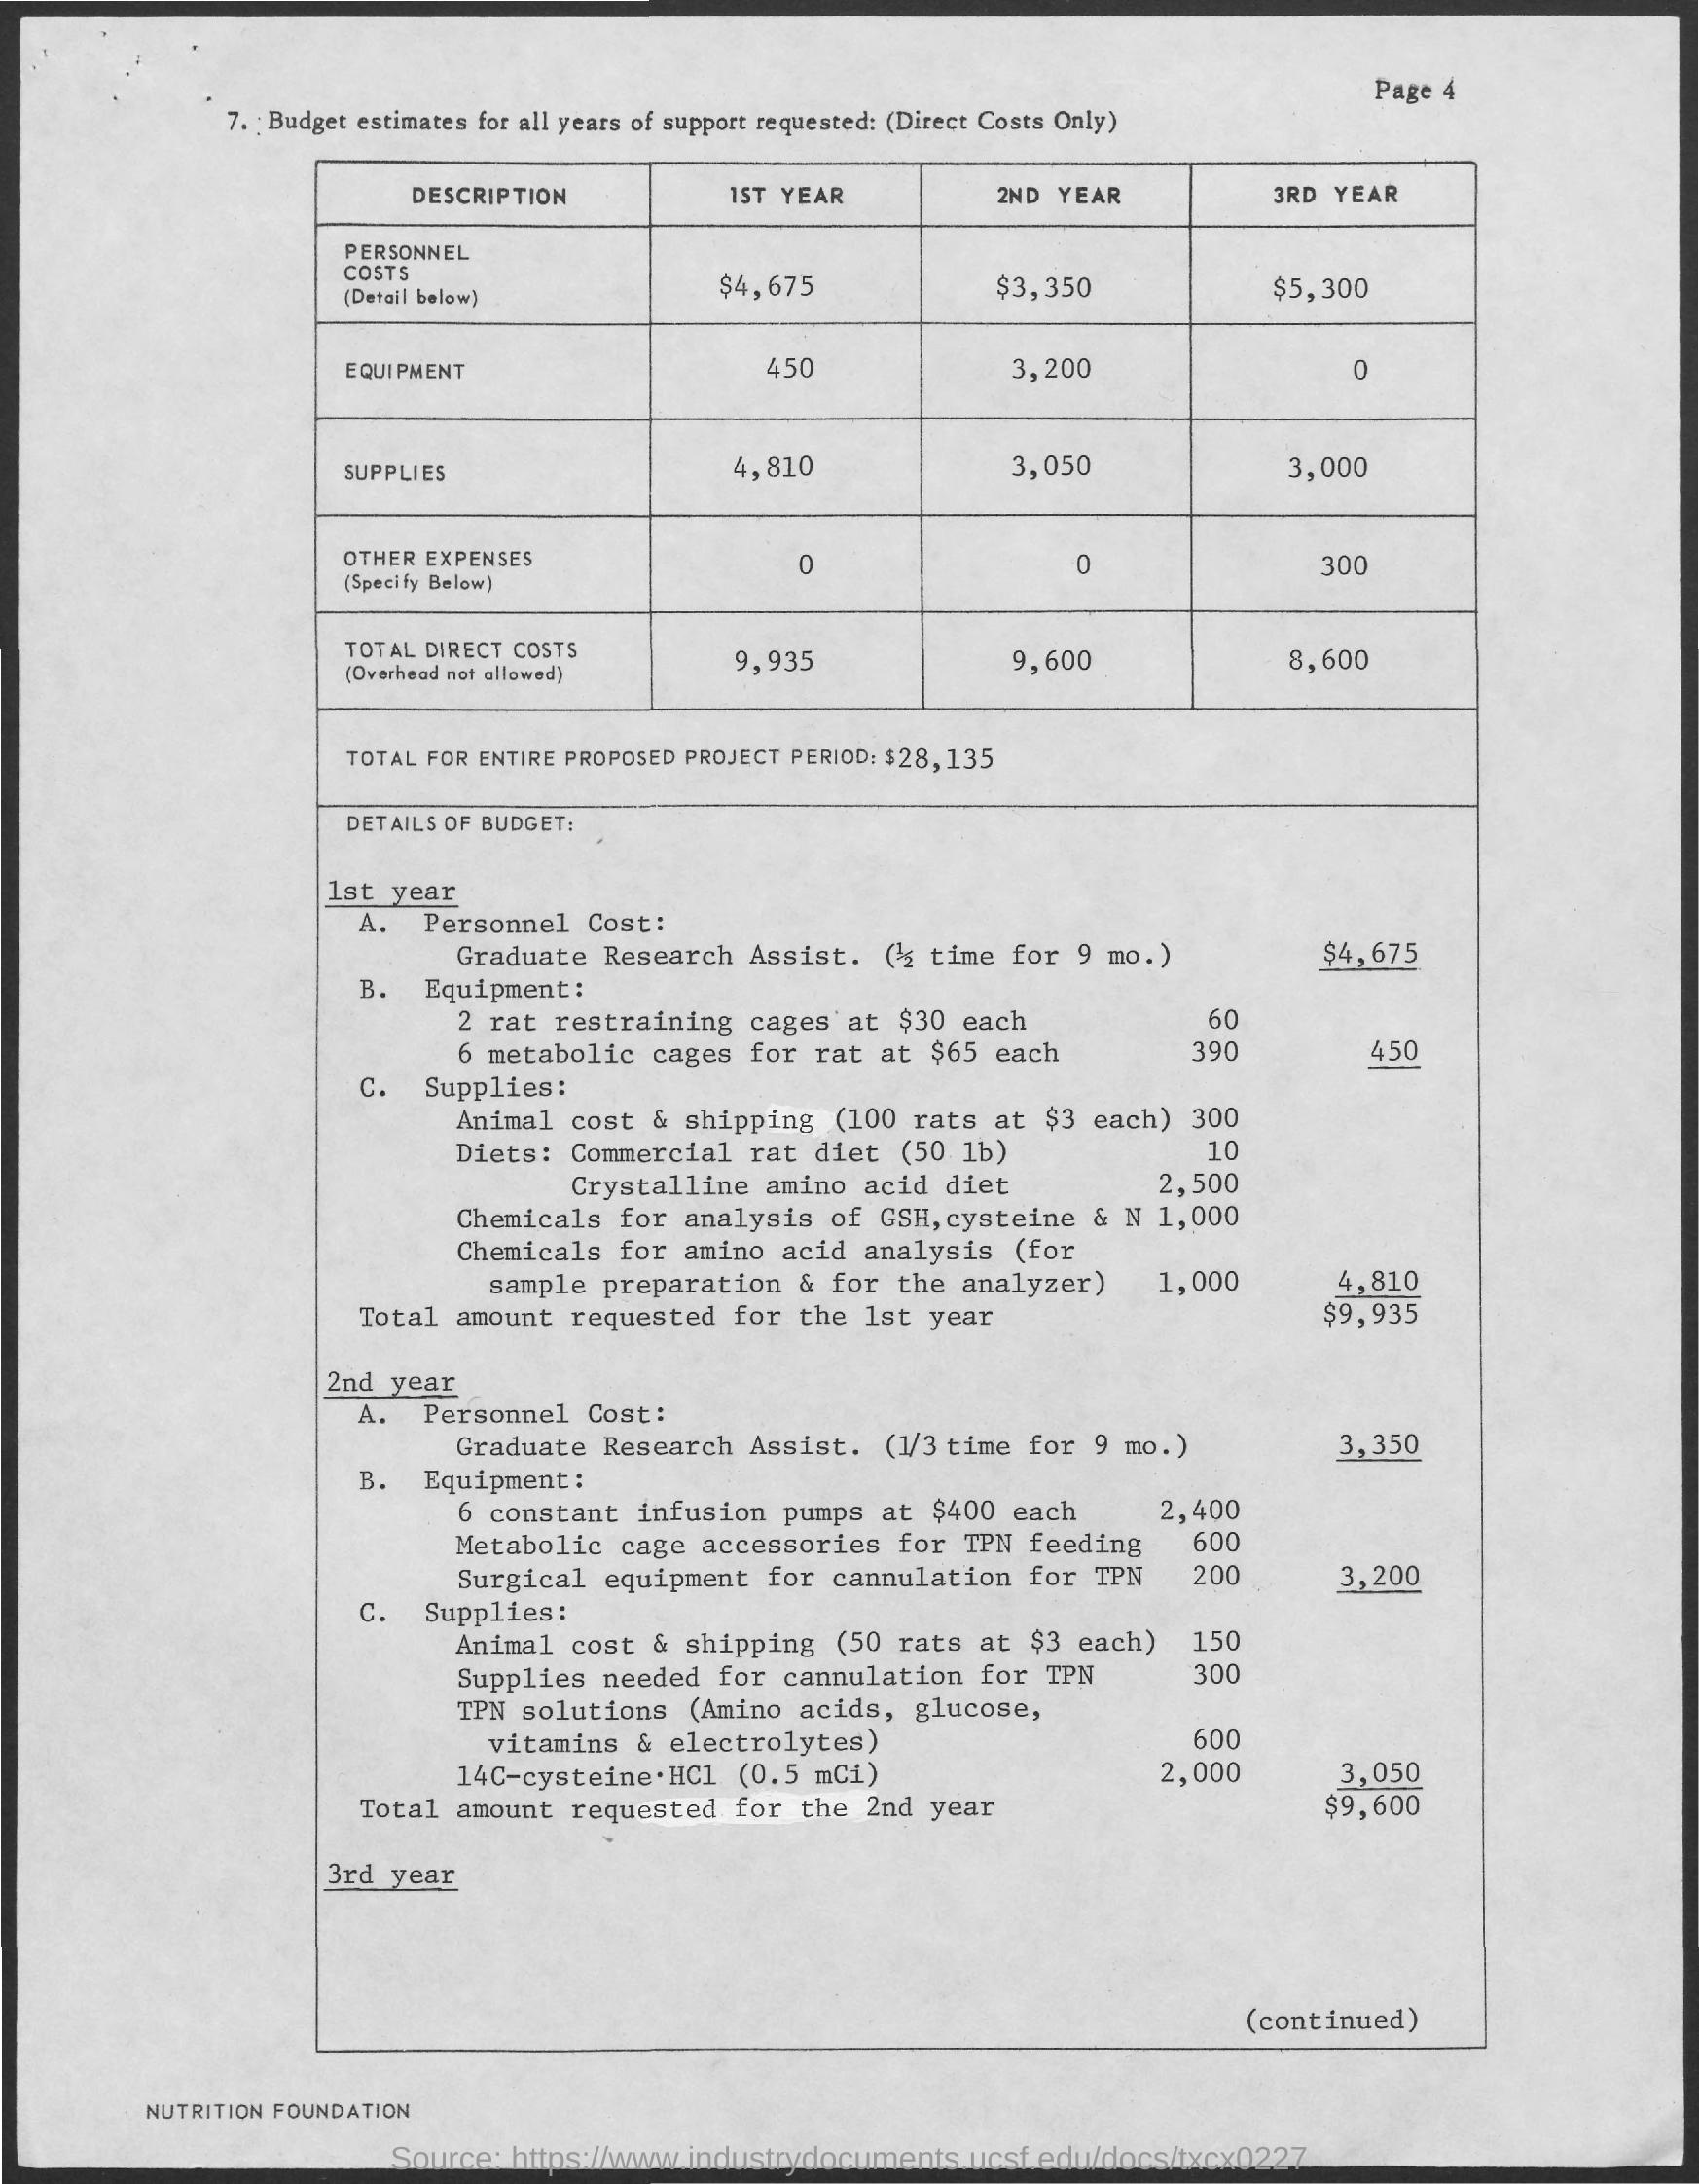

In [19]:
img_d0[10]#.rotate(90)

In [20]:
# rag.precompute_encodings(0)

TODO: currently i'm using sentences as chunks, I should try bigger chunks. I believe a single sentence doesn't give bert enough context to form a good embedding that then matches the question.
Even if the question is "What is the name" and the answer the actual name, the similarity won't match between them but maybe with context arround.

In [42]:
class RAG:
	def __init__(
		self,
		device: torch.device,
		model_type: Literal["fasttext", "bert"]="bert",
	):
		self.device = device
		self.model_type = model_type
		if model_type == "fasttext":
			print("Loading fasttext model...")
			if not os.path.exists(os.path.join(ROOT, "cc.en.300.bin")):
				fasttext.util.download_model('en', if_exists='ignore')
			self.fasttext_model = fasttext.load_model(os.path.join(ROOT, "cc.en.300.bin"))
			self.dim = self.fasttext_model.get_dimension()
		elif model_type == "bert":
			self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
			self.model = BertModel.from_pretrained('bert-base-uncased')
			self.dim = 768
		else:
			raise ValueError("model should be either 'fasttext' or 'bert'.")
		
	def encode(self, text: str) -> torch.Tensor:
		if self.model_type == "fasttext":
			return torch.tensor(self.fasttext_model.get_sentence_vector(text), device=self.device)
		elif self.model_type == "bert":
			enc = self.tokenizer.batch_encode_plus([text], padding=True, truncation=True, return_tensors='pt', add_special_tokens=True)
			with torch.no_grad():
				outputs = self.model(enc["input_ids"], attention_mask=enc["attention_mask"])
				return outputs.last_hidden_state[:, 0, :]
	
	def get_chunks(self, ocr_dX: List[dict], chunk_size: int = 0) -> List[List[str]]:
		"""If chunk_size is 0, then chunks are lines, else chunk_size is the nº of words"""
		assert chunk_size >= 0, "chunk_size should be a non-negative integer."
		if chunk_size == 0:
			return [[line["Text"] for line in page["LINE"]] for page in ocr_dX]
		else:
			chunks_ocrX_dX = []
			for page in range(len(ocr_dX)):
				page_text = " ".join([line["Text"] for line in ocr_dX[page]["LINE"]])
				words = page_text.split()
				chunks_ocrX_dX.append([" ".join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)])
			return chunks_ocrX_dX

	def precompute_encodings(self, doc_idx: int, chunk_size: int = 0):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		chunks_ocrX_dX = self.get_chunks(ocr_dX, chunk_size)
		print("Encoding chunks...")
		embs_chunks = [[self.encode(chunk) for chunk in page_chunks] for page_chunks in tqdm(chunks_ocrX_dX)]
		embs_chunks = [torch.stack(page_chunks) for page_chunks in embs_chunks]

		print("Saving encodings...")
		torch.save(embs_chunks, f"encodings/encodings_{name_dX}_{chunk_size}.pt")

	def most_similar(
			self,
			quest: str,
			chunks: List[List[str]],
			embs_chunks: List[torch.Tensor],
			topk: int = 5,
			similarity_type: Literal["cosine", "dot"]="cosine"
	) -> List[Tuple[int, str]]:
		print("Encoding")
		embs_quest = self.encode(quest)

		# Compute similarity in a vectorized manner
		print("Computing similarity")
		sims_list = []
		for page_embs in embs_chunks:
			page_embs = page_embs.squeeze(1) # [num_chunks, dim]
			if similarity_type == "cosine":
				norms_quest = torch.norm(embs_quest) # scalar
				norms_chunks = torch.norm(page_embs, dim=1) # [num_chunks]
				sims = torch.matmul(page_embs, embs_quest.T).squeeze(1) / (norms_quest * norms_chunks) # [num_chunks, num_lines]
			elif similarity_type == "dot":
				sims = torch.matmul(embs_quest, page_embs.T)
			else:
				raise ValueError("type should be either 'cosine' or 'dot'.")
			sims_list.append(sims)

		# Flatten the similarities and get the top-k indices
		print("Sorting")
		sims_flat = torch.cat(sims_list)
		sorted_indices = torch.argsort(sims_flat, descending=True)[:topk]

		# Retrieve the most similar chunks
		print("Retrieving")
		most_similar_chunks = []
		for idx in sorted_indices:
			page_idx = 0
			while idx >= len(sims_list[page_idx]):
				idx -= len(sims_list[page_idx])
				page_idx += 1
			most_similar_chunks.append((page_idx, chunks[page_idx][idx.item()]))

		return most_similar_chunks  # [(page_idx, chunk), ...]

	def foo(
			self,
			doc_idx: int,
			quest_idx: int,
			topk: int=5,
			use_precomputed: bool = True,
			chunk_size: int = 0
	):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		chunks_ocrX_dX = self.get_chunks(ocr_dX, chunk_size)
		trainset = json.load(open("qas/train.json"))
		qas_dX = [qa for qa in trainset["data"] if qa["doc_id"] == name_dX]
		questX_dX = qas_dX[quest_idx]["question"]
		ansrsX_dX = qas_dX[quest_idx]

		if use_precomputed and os.path.exists(f"encodings/encodings_{name_dX}_{chunk_size}.pt"):
			print("Loading precomputed encodings...")
			embs_chunks = torch.load(f"encodings/encodings_{name_dX}_{chunk_size}.pt")
		else:
			print("Encoding chunks...")
			self.precompute_encodings(doc_idx, chunk_size)
			embs_chunks = torch.load(f"encodings/encodings_{name_dX}_{chunk_size}.pt")

		print("Computing most similar chunks...")
		most_similar_chunks = self.most_similar(questX_dX, chunks_ocrX_dX, embs_chunks, topk)
		print("-" * 20)

		print(f"Question:\n- {questX_dX}")
		print("Most similar OCR chunks:")
		for i, (page_idx, chunk) in enumerate(most_similar_chunks):
			print(f"Page {page_idx} - {chunk}")
		print(f"Actual answers in page: {ansrsX_dX['answer_page_idx']}")
		for ansr in ansrsX_dX["answers"]:
			print(f"- {ansr}")
		print("page_ids:", ansrsX_dX["page_ids"])
		

rag = RAG(device, model_type="bert")
rag.foo(
	doc_idx=0,
	quest_idx=3,
	chunk_size=30
)

Loading data...
Loading precomputed encodings...
Computing most similar chunks...
Encoding
Computing similarity
Sorting
Retrieving
--------------------
Question:
- What is the marital status given in resume
Most similar OCR chunks:
Page 7 - out during the third year of the project. Reference cited: Attached
Page 7 - has agreed to provide me with the needed time on the analytical instruments (see attached letter from Dr. L. D. Stegink concerning the usage of his equipment) Future studies: If
Page 2 - (continued) NUTRITION FOUNDATION
Page 15 - of The Graduate College Mail to: The Nutrition Foundation 489 Fifth Avenue New York, N.Y. 10017 Source:
Page 1 - NUTRITION FOUNDATION
Actual answers in page: 3
- Single
page_ids: ['txcx0227_p15', 'txcx0227_p16', 'txcx0227_p17', 'txcx0227_p18', 'txcx0227_p19']


In [43]:
name_dX = os.listdir("ocr")[0][:8]
filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
chunks_ocr_dX = rag.get_chunks(ocr_dX, 30)

In [44]:
chunks_ocr_dX[0]

['CHO, Ei SOON Page 1 F.L. NF THE NUTRITION FOUNOATION, 489 FIFTH AVENUE NEW YORK, . NEW YORK 10017 (212) 68 JUL 5 1978 Application for Grant-in-Aid Date: June 21,',
 '1978 Ei Soon Cho 1. Applicant: Assistant Professor, Department of Home Economics 2. Position and institution: University of Iowa, Iowa City, Iowa 52242 Sulfur-containing amino acid metabolism during 3. Subject',
 'or title of project: total parenteral nutrition in growing rats. 3a. Duration of project: three years 3b. Total Budget: $28,135 4. Significance of project to nutrition: Present data indicate that',
 'cystine is an essential for some premature infants due to the absence of the enzyme cystathionase. However, cystine cannot be added to parenteral solutions in adequate amounts because of limited',
 'solubility, suggesting that infants fed totally by vein may become cystine deficient. This study proposes to: a) investigate the metabolism of sulfur-containing amino acids during total parenteral nutrition; b) evaluate

Trying a different model

In [68]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# https://docs.llamaindex.ai/en/stable/examples/embeddings/huggingface/

class RAG:
	def __init__(
		self,
		device: torch.device,
		model_type: Literal["fasttext", "bert", "bge"]="bert",
	):
		self.device = device
		self.model_type = model_type
		if model_type == "fasttext":
			print("Loading fasttext model...")
			if not os.path.exists(os.path.join(ROOT, "cc.en.300.bin")):
				fasttext.util.download_model('en', if_exists='ignore')
			self.fasttext_model = fasttext.load_model(os.path.join(ROOT, "cc.en.300.bin"))
			self.dim = self.fasttext_model.get_dimension()
		elif model_type == "bert":
			self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
			self.model = BertModel.from_pretrained('bert-base-uncased')
			self.dim = 768
		elif model_type == "bge":
			self.model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
			self.dim = 384
		else:
			raise ValueError("model should be either 'fasttext' or 'bert'.")
		
	def encode(self, text: str) -> torch.Tensor:
		if self.model_type == "fasttext":
			return torch.tensor(self.fasttext_model.get_sentence_vector(text), device=self.device)
		elif self.model_type == "bert":
			enc = self.tokenizer.batch_encode_plus([text], padding=True, truncation=True, return_tensors='pt', add_special_tokens=True)
			with torch.no_grad():
				outputs = self.model(enc["input_ids"], attention_mask=enc["attention_mask"])
				return outputs.last_hidden_state[:, 0, :]
		elif self.model_type == "bge":
			return torch.tensor(self.model.get_text_embedding(text)).to(self.device)
	
	def get_chunks(self, ocr_dX: List[dict], chunk_size: int = 0) -> List[List[str]]:
		"""If chunk_size is 0, then chunks are lines, else chunk_size is the nº of words"""
		assert chunk_size >= 0, "chunk_size should be a non-negative integer."
		if chunk_size == 0:
			page_chunks = []
			for page in ocr_dX:
				if "LINE" in page:
					page_chunks.append([line["Text"] for line in page["LINE"]])
		else:
			chunks_ocrX_dX = []
			for page in range(len(ocr_dX)):
				if "LINE" in ocr_dX[page]:
					page_text = " ".join([line["Text"] for line in ocr_dX[page]["LINE"]])
				words = page_text.split()
				chunks_ocrX_dX.append([" ".join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)])
			return chunks_ocrX_dX

	def precompute_encodings(self, doc_idx: int, chunk_size: int = 0):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		chunks_ocrX_dX = self.get_chunks(ocr_dX, chunk_size)
		print("Encoding chunks...")
		embs_chunks = [[self.encode(chunk) for chunk in page_chunks] for page_chunks in tqdm(chunks_ocrX_dX)]
		embs_chunks = [torch.stack(page_chunks) for page_chunks in embs_chunks]

		print("Saving encodings...")
		torch.save(embs_chunks, f"encodings/{self.model_type}_{name_dX}_{chunk_size}.pt")

	def most_similar(
			self,
			quest: str,
			chunks: List[List[str]],
			embs_chunks: List[torch.Tensor],
			topk: int = 5,
			similarity_type: Literal["cosine", "dot"]="cosine"
	) -> List[Tuple[int, str]]:
		print("Encoding question...")
		embs_quest = self.encode(quest)
		if embs_quest.dim() == 1:
			embs_quest = embs_quest.unsqueeze(0)

		# Compute similarity in a vectorized manner
		print("Computing similarity...")
		sims_list = []
		for page_embs in embs_chunks:
			if self.model_type == "bert":
				page_embs = page_embs.squeeze(1) # [num_chunks, dim]
			if similarity_type == "cosine":
				norms_quest = torch.norm(embs_quest) # scalar
				norms_chunks = torch.norm(page_embs, dim=1) # [num_chunks]
				sims = torch.matmul(page_embs, embs_quest.T).squeeze(1) / (norms_quest * norms_chunks) # [num_chunks, num_lines]
			elif similarity_type == "dot":
				sims = torch.matmul(embs_quest, page_embs.T)
			else:
				raise ValueError("type should be either 'cosine' or 'dot'.")
			sims_list.append(sims)

		# Flatten the similarities and get the top-k indices
		print("Sorting...")
		sims_flat = torch.cat(sims_list)
		sorted_indices = torch.argsort(sims_flat, descending=True)[:topk]

		# Retrieve the most similar chunks
		print("Retrieving...")
		most_similar_chunks = []
		for idx in sorted_indices:
			page_idx = 0
			while idx >= len(sims_list[page_idx]):
				idx -= len(sims_list[page_idx])
				page_idx += 1
			most_similar_chunks.append((page_idx, chunks[page_idx][idx.item()]))

		return most_similar_chunks  # [(page_idx, chunk), ...]

	def foo(
			self,
			doc_idx: int,
			quest_idx: int,
			topk: int=5,
			use_precomputed: bool = True,
			chunk_size: int = 0
	):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		chunks_ocrX_dX = self.get_chunks(ocr_dX, chunk_size)
		trainset = json.load(open("qas/train.json"))
		qas_dX = [qa for qa in trainset["data"] if qa["doc_id"] == name_dX]
		print(f"Document {name_dX} has {len(qas_dX)} questions")
		questX_dX = qas_dX[quest_idx]["question"]
		ansrsX_dX = qas_dX[quest_idx]

		if use_precomputed and os.path.exists(f"encodings/{self.model_type}_{name_dX}_{chunk_size}.pt"):
			print("Loading precomputed encodings...")
			embs_chunks = torch.load(f"encodings/{self.model_type}_{name_dX}_{chunk_size}.pt")
		else:
			print("Encoding chunks...")
			self.precompute_encodings(doc_idx, chunk_size)
			embs_chunks = torch.load(f"encodings/{self.model_type}_{name_dX}_{chunk_size}.pt")

		print("Computing most similar chunks...")
		most_similar_chunks = self.most_similar(questX_dX, chunks_ocrX_dX, embs_chunks, topk)
		print("-" * 20)

		print(f"Question:\n- {questX_dX}")
		print("Most similar OCR chunks:")
		for i, (page_idx, chunk) in enumerate(most_similar_chunks):
			print(f"Page {page_idx} - {chunk}")
		# print(f"Actual answers in page: {ansrsX_dX['answer_page_idx']}")
		for ansr in ansrsX_dX["answers"]:
			print(f"- {ansr}")
		print("page_ids:", ansrsX_dX["page_ids"])
		

rag = RAG(device, model_type="bge")
rag.foo(
	doc_idx=1,
	quest_idx=5,
	chunk_size=20
)

TODO: Make overlapping windows as chunks, try different chunk sizes (bigger better?). 

---

In [1]:
from typing import Tuple, Literal, List, Union
from tqdm import tqdm
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import random
from transformers import BertTokenizer, BertModel
import fasttext
import fasttext.util
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
from PIL import Image

ROOT = os.path.dirname(os.path.abspath(""))
ROOT

# cosine similarity
def cos_sim(a, b):
	return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

name_d0 = os.listdir("ocr")[0][:8]
filenames_d0 = [file[:-5] for file in os.listdir("ocr") if name_d0 in file]
filenames_d0 = sorted(filenames_d0, key=lambda x: int(x[10:]))

# OCR
ocr_d0 = [json.load(open(f"ocr/{file}.json")) for file in filenames_d0]

# Images
img_d0 = [Image.open(f"images/{file}.jpg") for file in filenames_d0]

# Questions and Answers
dataset = json.load(open("qas/train.json"))
qas_d0 = [qa for qa in dataset["data"] if qa["doc_id"] == name_d0]

# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
# Load BERT tokenizer and model
tokenizer: BertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model: BertModel = BertModel.from_pretrained('bert-base-uncased')

/home/eric/miniconda3/envs/computer_vision_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class RAG:
	def __init__(
		self,
		device: torch.device,
		model_type: Literal["fasttext", "bert", "bge"]="bert",
	):
		self.device = device
		self.model_type = model_type
		if model_type == "fasttext":
			print("Loading fasttext model...")
			if not os.path.exists(os.path.join(ROOT, "cc.en.300.bin")):
				fasttext.util.download_model('en', if_exists='ignore')
			self.fasttext_model = fasttext.load_model(os.path.join(ROOT, "cc.en.300.bin"))
			self.dim = self.fasttext_model.get_dimension()
		elif model_type == "bert":
			self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
			self.model = BertModel.from_pretrained('bert-base-uncased')
			self.dim = 768
		elif model_type == "bge":
			self.model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
			self.dim = 384
		else:
			raise ValueError("model should be either 'fasttext' or 'bert'.")
		
	def encode(self, text: str) -> torch.Tensor:
		if self.model_type == "fasttext":
			return torch.tensor(self.fasttext_model.get_sentence_vector(text), device=self.device)
		elif self.model_type == "bert":
			enc = self.tokenizer.batch_encode_plus([text], padding=True, truncation=True, return_tensors='pt', add_special_tokens=True)
			with torch.no_grad():
				outputs = self.model(enc["input_ids"], attention_mask=enc["attention_mask"])
				return outputs.last_hidden_state[:, 0, :]
		elif self.model_type == "bge":
			return torch.tensor(self.model.get_text_embedding(text), device=self.device)
	
	def get_chunks(
		self, ocr_dX: List[dict], chunk_size: int = 0, overlap_size: int = 0
	) -> List[List[str]]:
		"""If chunk_size is 0, then chunks are lines, else chunk_size is the nº of words.
		Overlap is the number of words to overlap between chunks."""
		
		assert chunk_size >= 0, "chunk_size should be a non-negative integer."
		assert overlap_size >= 0, "overlap_size should be a non-negative integer."
		assert overlap_size < chunk_size, "overlap_size should be less than chunk_size."
		
		if chunk_size == 0:
			# If no chunking, return lines as chunks
			page_chunks = []
			for page in ocr_dX:
				if "LINE" in page:
					page_chunks.append([line["Text"] for line in page["LINE"]])
			return page_chunks

		else:
			# If chunk_size > 0, use words as chunks
			chunks_ocrX_dX = []
			for page in range(len(ocr_dX)):
				if "LINE" in ocr_dX[page]:
					# Join all lines in the page into a single string
					page_text = " ".join([line["Text"] for line in ocr_dX[page]["LINE"]])
					
					# Split the page text into words
					words = page_text.split()
					
					# Create chunks with overlap
					chunks = []
					for i in range(0, len(words), chunk_size - overlap_size):
						chunk = " ".join(words[i:i + chunk_size])
						chunks.append(chunk)
					
					# Append the chunks for this page
					chunks_ocrX_dX.append(chunks)
					
			return chunks_ocrX_dX

	def precompute_encodings(self, doc_idx: int, chunk_size: int = 0, overlap_size: int = 0):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		chunks_ocrX_dX = self.get_chunks(ocr_dX, chunk_size, overlap_size)
		print("Encoding chunks...")
		embs_chunks = [[self.encode(chunk) for chunk in page_chunks] for page_chunks in tqdm(chunks_ocrX_dX)]
		embs_chunks = [torch.stack(page_chunks) for page_chunks in embs_chunks]

		print("Saving encodings...")
		torch.save(embs_chunks, f"encodings/{self.model_type}_{name_dX}_{chunk_size}_{overlap_size}.pt")

	def most_similar(
			self,
			quest: str,
			chunks: List[List[str]],
			embs_chunks: List[torch.Tensor],
			topk: int = 5,
			similarity_type: Literal["cosine", "dot"]="cosine"
	) -> List[Tuple[int, str]]:
		print("Encoding question...")
		embs_quest = self.encode(quest)
		if embs_quest.dim() == 1:
			embs_quest = embs_quest.unsqueeze(0)

		# Compute similarity in a vectorized manner
		print("Computing similarity...")
		sims_list = []
		for page_embs in embs_chunks:
			if self.model_type == "bert":
				page_embs = page_embs.squeeze(1) # [num_chunks, dim]
			if similarity_type == "cosine":
				norms_quest = torch.norm(embs_quest) # scalar
				norms_chunks = torch.norm(page_embs, dim=1) # [num_chunks]
				sims = torch.matmul(page_embs, embs_quest.T).squeeze(1) / (norms_quest * norms_chunks) # [num_chunks, num_lines]
			elif similarity_type == "dot":
				sims = torch.matmul(embs_quest, page_embs.T)
			else:
				raise ValueError("type should be either 'cosine' or 'dot'.")
			sims_list.append(sims)

		# Flatten the similarities and get the top-k indices
		print("Sorting...")
		sims_flat = torch.cat(sims_list)
		sorted_indices = torch.argsort(sims_flat, descending=True)[:topk]

		# Retrieve the most similar chunks
		print("Retrieving...")
		most_similar_chunks = []
		for idx in sorted_indices:
			page_idx = 0
			while idx >= len(sims_list[page_idx]):
				idx -= len(sims_list[page_idx])
				page_idx += 1
			most_similar_chunks.append((page_idx, chunks[page_idx][idx.item()]))

		return most_similar_chunks  # [(page_idx, chunk), ...]

	def foo(
			self,
			doc_idx: int,
			quest_idx: int,
			topk: int=5,
			use_precomputed: bool = True,
			chunk_size: int = 20,
			overlap_size: int = 5
	):
		print("Loading data...")
		name_dX = os.listdir("ocr")[doc_idx][:8]
		filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
		filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
		ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
		chunks_ocrX_dX = self.get_chunks(ocr_dX, chunk_size, overlap_size)
		trainset = json.load(open("qas/train.json"))
		qas_dX = [qa for qa in trainset["data"] if qa["doc_id"] == name_dX]
		print(f"Document {name_dX} has {len(qas_dX)} questions")
		questX_dX = qas_dX[quest_idx]["question"]
		ansrsX_dX = qas_dX[quest_idx]

		if use_precomputed and os.path.exists(f"encodings/{self.model_type}_{name_dX}_{chunk_size}_{overlap_size}.pt"):
			print("Loading precomputed encodings...")
			embs_chunks = torch.load(f"encodings/{self.model_type}_{name_dX}_{chunk_size}_{overlap_size}.pt")
		else:
			print("Encoding chunks...")
			self.precompute_encodings(doc_idx, chunk_size, overlap_size)
			embs_chunks = torch.load(f"encodings/{self.model_type}_{name_dX}_{chunk_size}_{overlap_size}.pt")

		print("Computing most similar chunks...")
		most_similar_chunks = self.most_similar(questX_dX, chunks_ocrX_dX, embs_chunks, topk)
		print("-" * 20)

		print(f"Question:\n- {questX_dX}")
		print("Most similar OCR chunks:")
		for i, (page_idx, chunk) in enumerate(most_similar_chunks):
			print(f"Page {page_idx} - {chunk}")
		print(f"Actual answers in page: {ansrsX_dX['page_ids'][ansrsX_dX['answer_page_idx']-1][10:]}")
		for ansr in ansrsX_dX["answers"]:
			print(f"- {ansr}")
		

rag = RAG(device, model_type="bge")
rag.foo(
	doc_idx=1,
	quest_idx=10,
	chunk_size=30,
	overlap_size=10
)

Loading data...
Document jzhd0227 has 76 questions
Loading precomputed encodings...
Computing most similar chunks...
Encoding question...
Computing similarity...
Sorting...
Retrieving...
--------------------
Question:
- what is the % of members said can't recall if asked as a reason for not giving mentioned in the given page ?
Most similar OCR chunks:
Page 82 - CONTRIBUTORS TON-CONTRIBUTORS 30% 70% REASON FOR NOT GIVING REFUSED TO GIVE CAN'T RECALL IF NOT ASKED 4% ASKED 39% 27% IF ASKED, WOULD YOU HAVE GIVEN? DON'T KNOW NOT LIKELY
Page 76 - 81% of those reported they would have contributed if asked. (Please see Exhibit B) WHAT SHOULD WE DO ABCUT THIS SITUATION? Source: https://www.industrydocuments.ucsf.edu/docs/jzhd0227
Page 82 - IF ASKED, WOULD YOU HAVE GIVEN? DON'T KNOW NOT LIKELY FAIRLY LIKELY VERY LIKELY 2% 5% 18% 14% Source: Adapted from the Gallup Study of Public Awareness and Image of
Page 82 - EXHIBIT - B REPORTED PATTERN OF GIVING TO AHA/HEART FUND DURING THE PAST YEAR TOTAL 

In [96]:
doc_idx = 1
quest_idx = 20
name_dX = os.listdir("ocr")[doc_idx][:8]
filenames_dX = [file[:-5] for file in os.listdir("ocr") if name_dX in file]
filenames_dX = sorted(filenames_dX, key=lambda x: int(x[10:]))
ocr_dX = [json.load(open(f"ocr/{file}.json")) for file in filenames_dX]
chunks_ocr_dX = rag.get_chunks(ocr_dX, 30, 10)
dataset = json.load(open("qas/train.json"))
ocr_dX = [qa for qa in dataset["data"] if qa["doc_id"] == name_dX]
print(f"Document {name_dX} has {len(ocr_dX)} questions")
questX_dX = ocr_dX[quest_idx]["question"]
ansrsX_dX = ocr_dX[quest_idx]

Document jzhd0227 has 76 questions


In [97]:
questX_dX, ansrsX_dX

('what day of week is mentioned in the page?',
 {'questionId': 25795,
  'question': 'what day of week is mentioned in the page?',
  'doc_id': 'jzhd0227',
  'page_ids': ['jzhd0227_p70', 'jzhd0227_p71', 'jzhd0227_p72', 'jzhd0227_p73'],
  'answers': ['Thursday'],
  'answer_page_idx': 3,
  'data_split': 'train'})

In [2]:
embs_d0 = torch.load("encodings/bge_jzhd0227_20_5.pt")
len(embs_d0), embs_d0[0].shape, embs_d0[1].shape
# (#pages), (#chunks, dim)

(84, torch.Size([25, 384]), torch.Size([2, 384]))

TODO:
- Adapt for multiple documents retrieval
- Append context before and after the retrieved chunks

---

In [1]:
from typing import Tuple, Literal, List, Union, Any, Optional, Iterable
from tqdm import tqdm
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import random
from transformers import BertTokenizer, BertModel
import fasttext
import fasttext.util
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
from PIL import Image

ROOT = os.path.dirname(os.path.abspath(""))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

/home/eric/miniconda3/envs/computer_vision_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eric/miniconda3/envs/computer_vision_env/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def load_model(model_type: str) -> Tuple[Any, int]:
	if model_type == "fasttext":
		print("Loading fasttext model...")
		if not os.path.exists(os.path.join(ROOT, "cc.en.300.bin")):
			fasttext.util.download_model('en', if_exists='ignore')
		model = fasttext.load_model(os.path.join(ROOT, "cc.en.300.bin"))
		dim = model.get_dimension()
	elif model_type == "bert":
		print("Loading BERT model...")
		tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
		model = BertModel.from_pretrained('bert-base-uncased')
		dim = 768
		return model, dim, tokenizer
	elif model_type == "bge":
		print("Loading BGE model...")
		model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
		dim = 384
	else:
		raise ValueError("model should be either 'fasttext' or 'bert'.")
	return model, dim

def load_dataset():
	return np.load("spdocvqa_imdb/imdb_train.npy", allow_pickle=True)[1:]

model = load_model("bge")
dataset = load_dataset()

Loading BGE model...


In [77]:
class RAG_SP:
	def __init__(
		self,
		device: torch.device,
		model_type: Literal["fasttext", "bert", "bge"]="bert",
		model: Optional[Any]=None,
		dataset: Optional[Iterable[dict]]=None
	):
		print("Initializing...")
		self.device = device
		self.model_type = model_type
		if model_type == "bert":
			if model is None:
				self.model, self.dim, self.tokenizer = load_model(model_type)
			else:
				self.model, self.dim, self.tokenizer = model
		else:
			if model is None:
				self.model, self.dim = load_model(model_type)
			else:
				self.model, self.dim = model
			
		
		print("Loading dataset...")
		if dataset is None:
			self.dataset = load_dataset()
		else:
			self.dataset = dataset

	def encode(self, text: str) -> torch.Tensor:
		if self.model_type == "fasttext":
			return torch.tensor(self.model.get_sentence_vector(text), device=self.device)
		elif self.model_type == "bert":
			enc = self.tokenizer.batch_encode_plus([text], padding=True, truncation=True, return_tensors='pt', add_special_tokens=True)
			with torch.no_grad():
				outputs = self.model(enc["input_ids"], attention_mask=enc["attention_mask"])
				return outputs.last_hidden_state[:, 0, :]
		elif self.model_type == "bge":
			return torch.tensor(self.model.get_text_embedding(text), device=self.device)
	
	def read_doc_data(self, doc_idx: Union[int, list]) -> Any:
		filenames_images = [filename[:-4] for filename in os.listdir("images")]
		# filenames_dataset = [qa["image_id"] for qa in self.dataset]
		# filenames = list(set(filenames_images) & set(filenames_dataset))
		filenames = list(set(filenames_images))
		print(f"Available document images: {len(filenames)}")
		if doc_idx == -1:
			doc_idxs = list(range(len(filenames)))
		elif isinstance(doc_idx, list):
			doc_idxs = doc_idx
		else:
			doc_idxs = [doc_idx]
		name_all, filenames_all, ocr_all = [], [], []
		for idx in doc_idxs:
			name_dX = filenames[idx][:8]
			filenames_dX = [file for file in filenames if name_dX in file]
			filenames_dX = sorted(filenames_dX, key=lambda x: int(x[9:]))
			ocr_dX = [json.load(open(f"spdocvqa_ocr/{file}.json")) for file in filenames_dX]
			name_all.append(name_dX)
			filenames_all.append(filenames_dX)
			ocr_all.append(ocr_dX)
		if isinstance(doc_idx, int) and doc_idx != -1:
			return name_all[0], filenames_all[0], ocr_all[0]
		else:
			return name_all, filenames_all, ocr_all

	def get_chunks(
		self, ocr_dX: List[dict], chunk_size: int = 50, overlap_size: int = 0
	) -> List[List[str]]:
		"""chunk_size is the nº of words.
		Overlap is the number of words to overlap between chunks."""
		
		assert chunk_size > 1, "chunk_size should be a non-negative non-zero integer."
		assert overlap_size >= 0, "overlap_size should be a non-negative integer."
		assert overlap_size < chunk_size, "overlap_size should be less than chunk_size."

		chunks_ocr_dX = []
		for page in range(len(ocr_dX)):
			if "recognitionResults" not in ocr_dX[page]:
				continue
			lines = ocr_dX[page]["recognitionResults"][0]["lines"]
			page_text = " ".join([line["text"] for line in lines])
			words = page_text.split()
			
			# Create chunks with overlap
			chunks = []
			for i in range(0, len(words), chunk_size - overlap_size):
				chunk = " ".join(words[i:i + chunk_size])
				chunks.append(chunk)
			
			# Append the chunks for this page
			chunks_ocr_dX.append(chunks)
				
		return chunks_ocr_dX

	def precompute_encodings(
			self,
			doc_idx: Union[int, list],
			chunk_size: int = 0,
			overlap_size: int = 0,
			name_all: Optional[Any]=None,
			ocr_all: Optional[Any]=None
	):
		if ocr_all is None:
			name_all, _, ocr_all = self.read_doc_data(doc_idx)
			if isinstance(doc_idx, int) and doc_idx != -1:
				ocr_all = [ocr_all]
		chunks_ocr_all = [self.get_chunks(ocr_dX, chunk_size, overlap_size) for ocr_dX in ocr_all]
		print("Encoding chunks...")
		for i, chunks_ocr_dX in enumerate(chunks_ocr_all):
			save_path = f"encodings/SP_{self.model_type}_{name_all[i]}_{chunk_size}_{overlap_size}.pt"
			if os.path.exists(save_path):
				continue
			embs_chunks_dX = []
			for page_chunks in tqdm(chunks_ocr_dX):
				embs_chunks_page = [self.encode(chunk) for chunk in page_chunks]
				embs_chunks_dX.append(torch.stack(embs_chunks_page))
			torch.save(embs_chunks_dX, save_path)

	def most_similar(
			self,
			quest: str,
			chunks: List[List[List[str]]],
			embs_chunks: List[torch.Tensor],
			topk: int = 5,
			similarity_type: Literal["cosine", "dot"]="cosine"
	) -> List[Tuple[int, str]]:
		print("Encoding question...")
		embs_quest = self.encode(quest)
		if embs_quest.dim() == 1:
			embs_quest = embs_quest.unsqueeze(0)

		# Compute similarity in a vectorized manner
		print("Computing similarity...")
		sims_list = []
		for page_embs in embs_chunks:
			if self.model_type == "bert":
				page_embs = page_embs.squeeze(1) # [num_chunks, dim]
			if similarity_type == "cosine":
				norms_quest = torch.norm(embs_quest) # scalar
				norms_chunks = torch.norm(page_embs, dim=1) # [num_chunks]
				sims = torch.matmul(page_embs, embs_quest.T).squeeze(1) / (norms_quest * norms_chunks) # [num_chunks, num_lines]
			elif similarity_type == "dot":
				sims = torch.matmul(embs_quest, page_embs.T)
			else:
				raise ValueError("type should be either 'cosine' or 'dot'.")
			sims_list.append(sims)

		# Flatten the similarities and get the top-k indices
		print("Sorting...")
		sims_flat = torch.cat(sims_list)
		sorted_indices = torch.argsort(sims_flat, descending=True)[:topk]

		# Retrieve the most similar chunks
		print("Retrieving...")
		most_similar_chunks = []
		for idx in sorted_indices:
			doc_idx = 0
			while idx >= sum(len(page) for page in chunks[doc_idx]):
				idx -= sum(len(page) for page in chunks[doc_idx])
				doc_idx += 1

			page_idx = 0
			while idx >= len(chunks[doc_idx][page_idx]):
				idx -= len(chunks[doc_idx][page_idx])
				page_idx += 1

			most_similar_chunks.append((doc_idx, page_idx, idx.item()))
		return most_similar_chunks  # [(doc_idx, page_idx, chunk_idx), ...]

	def retrieve_context(
		self,
		chunks: List[List[List[str]]],
		retrieval_chunks: List[Tuple[int, int, int]],
		add_context: int,
		overlap_size: int = 0
	) -> List[Tuple[int, int, str]]:
		# Retrieve chunk but also add_context words before and after (from chunks before and after)
		# if chunks before or after are from different pages, truncate so it's all from same page
		retrieved_context = []
		for doc_idx, page_idx, chunk_idx in retrieval_chunks:
			chunk = chunks[doc_idx][page_idx][chunk_idx]
			context_before, context_after = "", ""
			# Add context before
			words_before = add_context
			chunk_count = chunk_idx - 1
			while words_before > 0 and chunk_count >= 0:
				chunk_words = chunks[doc_idx][page_idx][chunk_count].split()
				if overlap_size > 0:
					chunk_words = chunk_words[:-overlap_size]  # Exclude overlapping words
				context_words = chunk_words[::-1][:words_before][::-1]
				words_before -= len(context_words)
				context_before = (" ".join(context_words) + " " + context_before).strip()
				chunk_count -= 1
			# Add context after
			words_after = add_context
			chunk_count = chunk_idx + 1
			while words_after > 0 and chunk_count < len(chunks[doc_idx][page_idx]):
				chunk_words = chunks[doc_idx][page_idx][chunk_count].split()
				if overlap_size > 0:
					chunk_words = chunk_words[overlap_size:]  # Exclude overlapping words
				context_words = chunk_words[:words_after]
				words_after -= len(context_words)
				context_after += " " + " ".join(context_words)
				chunk_count += 1
			full_context = (context_before + " " + chunk + context_after).strip()
			retrieved_context.append((doc_idx, page_idx, full_context))
		return retrieved_context

	def show_image(self, image_name: str, figure_size: Tuple[int, int] = (10, 10)):
		img_path = f"images/{image_name}.png"
		img = Image.open(img_path)
		plt.figure(figsize=figure_size)
		# grey cmap if single channel
		if len(np.array(img).shape) == 2:
			plt.imshow(img, cmap="gray")
		else:
			plt.imshow(img)
		plt.axis("off")
		plt.show()

	def count_docs(self):
		# returns the number of unique documents in the dataset
		return len(set(qa["image_id"][:8] for qa in self.dataset))

	def get_ocr_chunks(self, doc_idx: int, page_idx: int, chunk_size: int = 50, overlap_size: int = 0):
		# returns the OCR chunks for a specific document and page
		name_dX, filenames_dX, ocr_dX = self.read_doc_data(doc_idx)
		chunks_ocr_dX = self.get_chunks(ocr_dX, chunk_size, overlap_size)
		print(f"{name_dX}_{page_idx}")
		page_idx = filenames_dX.index(f"{name_dX}_{page_idx}")
		return chunks_ocr_dX[page_idx]

	def foo(
			self,
			doc_idx: int,
			quest_idx: Union[int, str], # if str, search question that contains it
			topk: int=5,
			chunk_size: int = 20,
			overlap_size: int = 5,
			add_context: int = 10
	):
		print("Loading data...")
		single = isinstance(doc_idx, int) and doc_idx != -1
		name_all, filenames_all, ocr_all = self.read_doc_data(doc_idx)
		if single:
			name_all, filenames_all, ocr_all = [name_all], [filenames_all], [ocr_all]
		chunks_ocr_all = [self.get_chunks(ocr_dX, chunk_size, overlap_size) for ocr_dX in ocr_all]
		qas_total = [qa for qa in self.dataset if qa["image_id"][:8] in name_all]
		if single:
			print(f"Document {name_all[0]} has {len(qas_total)} questions and {len(filenames_all[0])} images")
		else:
			total_images = sum([len(files) for files in filenames_all])
			print(f"{len(name_all)} documents have {len(qas_total)} questions and {total_images} images")
		if isinstance(quest_idx, str):
			quest_idx = next(i for i, qa in enumerate(qas_total) if quest_idx in qa["question"])
		questX = qas_total[quest_idx]["question"]
		ansrsX = set(qas_total[quest_idx]["answers"])
		corresponding_doc = 0
		for i in range(len(ocr_all)):
			if name_all[i] == qas_total[quest_idx]["image_name"][:8]:
				corresponding_doc = i
				break
		corresponding_page = qas_total[quest_idx]["image_name"][9:]

		# precompute encodings (will pass if already computed)
		self.precompute_encodings(doc_idx, chunk_size, overlap_size, name_all, ocr_all)
		embs_chunks_total = []
		for i in range(len(ocr_all)):
			save_path = f"encodings/SP_{self.model_type}_{name_all[i]}_{chunk_size}_{overlap_size}.pt"
			embs_chunks_total.extend(torch.load(save_path))

		print("Computing most similar chunks...")
		most_similar_chunks = self.most_similar(questX, chunks_ocr_all, embs_chunks_total, topk)
		retrieved_context = self.retrieve_context(chunks_ocr_all, most_similar_chunks, add_context, overlap_size)
		print("-" * 20)

		print(f"Question:\n- {questX}")
		print("Retrieved context:")
		for i, (doc_idx, page_idx, context) in enumerate(retrieved_context):
			page_idx = filenames_all[doc_idx][page_idx][9:] # in case page numbers are not consecutive in filenames
			print(f"Document {doc_idx} - Page {page_idx} - {context}")
		print(f"Actual answers in document {corresponding_doc} - page {corresponding_page} ({qas_total[quest_idx]['image_id']})")
		for ansr in ansrsX:
			print(f"- {ansr}")
		

rag = RAG_SP(device, model_type="bge", model=model, dataset=dataset)

rag.foo(
	doc_idx=list(range(50)),
	quest_idx="what is the amount of profit after taxation",
	chunk_size=30,
	overlap_size=10,
	add_context=10
)

Initializing...
Loading dataset...
Loading data...
Available document images: 12767
50 documents have 1299 questions and 469 images
Encoding chunks...
Computing most similar chunks...
Encoding question...
Computing similarity...
Sorting...
Retrieving...
--------------------
Question:
- what is the amount of profit after taxation for the year ended 31.03.2004 ?
Retrieved context:
Document 0 - Page 84 - SUMMARY OF FINANCIAL RESULTS: For the year For the year Ended Ended 31.03.2004 31.03.2003 (Rs. in lacs) Profit for the year before Interest, Depreciation and Exceptional Items 2961.59 2697.42 Interest 1145.90 1047.79 Depreciation 240.76 Profit before Tax and Exceptional Items 1574.93 281.73 Exceptional Items (289.65) 1367.90 (454.68) Depreciation of Earlier
Document 0 - Page 84 - Your Directors hereby submit their Forty Eighth Annual Report with the Audited Accounts for the year ended 31" March, 2004. SUMMARY OF FINANCIAL RESULTS: For the year For the year Ended Ended 31.03.2004 31.03.200

In [78]:
rag.get_ocr_chunks(0, 84)

Available document images: 12767
fsgj0223_84


['GTL REPORT OF THE DIRECTORS AND MANAGEMENT DISCUSSION & ANALYSIS Your Directors hereby submit their Forty Eighth Annual Report with the Audited Accounts for the year ended 31" March, 2004. SUMMARY OF FINANCIAL RESULTS: For the year For the year Ended Ended 31.03.2004 31.03.2003 (Rs. in lacs) Profit for the',
 'year before Interest, Depreciation and Exceptional Items 2961.59 2697.42 Interest 1145.90 1047.79 Depreciation 240.76 Profit before Tax and Exceptional Items 1574.93 281.73 Exceptional Items (289.65) 1367.90 (454.68) Depreciation of Earlier years 1285.28 145.94 Profit before Taxation 767.28 Provision for Taxation : Current Tax (Wealth Tax) 5.75 5.09 Deferred Tax 531.81',
 "286.97 Profit after Taxation 747.72 475.22 Amount transferred from Debenture Redemption Reserve 350.00 Balance brought forward from last year (13098.08) (13923.30) Balance of loss carried over to Balance Sheet 12350.36) (13098.08) INDUSTRY STRUCTURE AND DEVELOPMENT: The Industry posted a 3% growth in volumes 

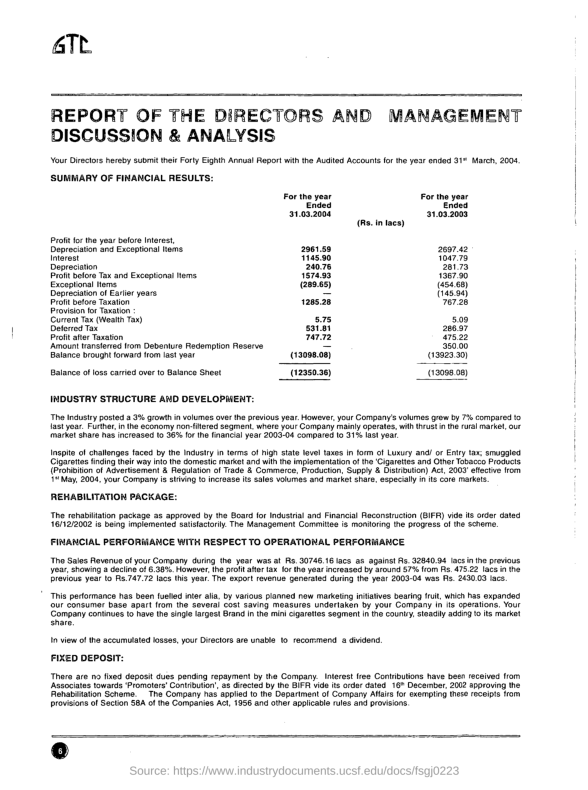

In [79]:
rag.show_image("fsgj0223_84")

TODO:
- Bring code to VM
- Escalate, encode more documents
- Try bigger chunk sizes if necessary